<a href="https://colab.research.google.com/github/prayas99/K-Means-Clustering-on-Text-and-Image-Data/blob/main/K_Means_Clustering_on_Text_and_Image_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
import cv2
from sklearn.decomposition import PCA

# Task 1

# Path of periodic table data

In [ ]:
path = 'path_to_file/periodic_t_info.csv'

In [ ]:
df = pd.read_csv(path,index_col=0)
df = df.reset_index(drop=True)
df.head()

sym  num    en   rad  thermal_K  density        crys
0   H    1  2.20  0.25     0.1805   0.0708      diatom
1  Li    3  0.98  1.45    85.0000   0.5340         BCC
2  Be    4  1.57  1.05   190.0000   1.8480         hcp
3   B    5  2.04  0.85    27.0000   2.3400  Tetragonal
4   C    6  2.55  0.70   140.0000   2.2000     Diamond

In [ ]:
df2 = df['thermal_K']
df2 = df2.sort_values()
df2 = pd.DataFrame(df2)
df2.head()

thermal_K
14    0.00890
5     0.02583
6     0.02658
7     0.02770
31    0.12000

In [ ]:
df2['Segment'] = pd.qcut(df2.thermal_K, 7).cat.codes
df2.head()

thermal_K  Segment
14    0.00890        0
5     0.02583        0
6     0.02658        0
7     0.02770        0
31    0.12000        0

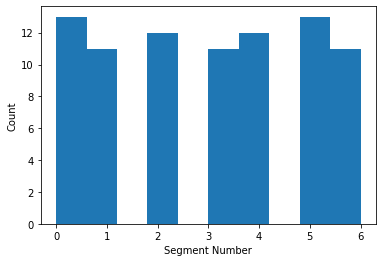

In [ ]:
plt.hist(df2['Segment'])
plt.xlabel('Segment Number')
plt.ylabel('Count')
plt.show()

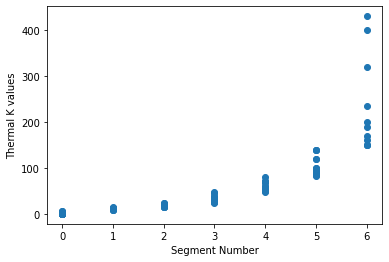

In [ ]:
plt.scatter(df2['Segment'],df2['thermal_K'])
plt.xlabel('Segment Number')
plt.ylabel('Thermal K values')
plt.show()

Segment column values are 0-indexed, so we will remove 1st, 3rd and 5th index and take 0,2,4,6 indexed columns

In [ ]:
df3 = df2[df2['Segment'] % 2 ==0]
df3 = df3.sample(frac=1).reset_index(drop=True)
df3.head()

thermal_K  Segment
0   16.00000        2
1  320.00000        6
2    0.02583        0
3    0.02770        0
4   20.00000        2

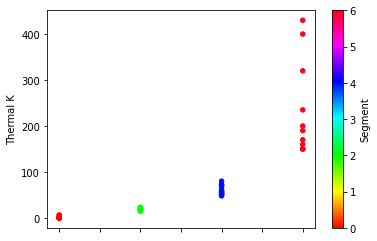

In [ ]:
df3.plot.scatter('Segment', 'thermal_K', c='Segment', colormap='hsv')
plt.xlabel('Segment Number')
plt.ylabel('Thermal K')
plt.show()

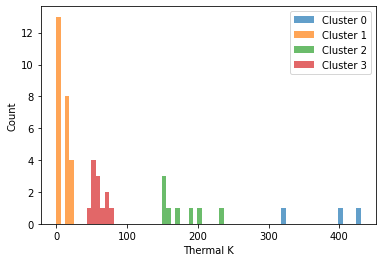

In [ ]:
data = df3['thermal_K'].values
cluster_id = KMeans(4).fit_predict(data.reshape(-1, 1))

fig, ax = plt.subplots()
bins = np.linspace(data.min(), data.max(), 70)
for ii in np.unique(cluster_id):
    subset = data[cluster_id==ii]
    ax.hist(subset, bins=bins, alpha=0.7, label=f"Cluster {ii}")
ax.legend()
plt.xlabel('Thermal K')
plt.ylabel('Count')
plt.show()

In [ ]:
K = range(1,10)
sse = []
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data.reshape(-1, 1))
    sse.append(kmeanModel.inertia_)

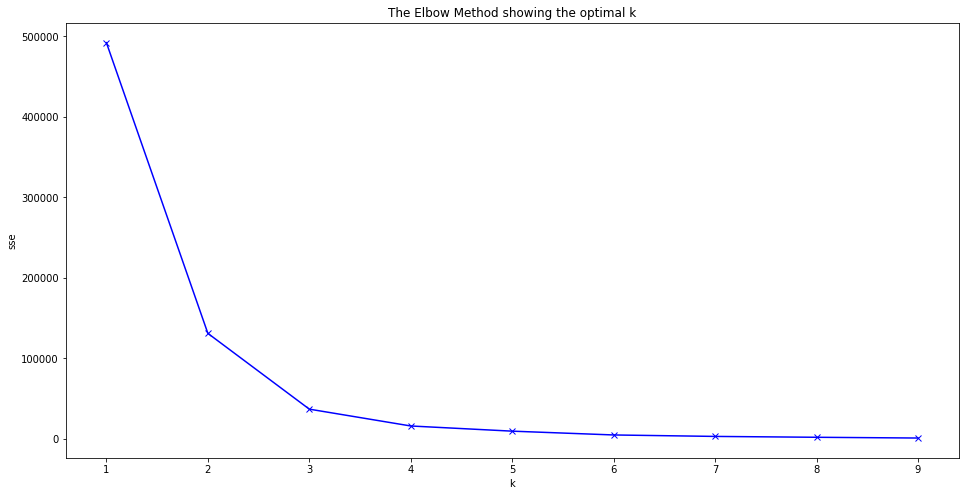

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('sse')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can see elbow of curve is also at k=4, so clustering is working fine

# Task 2

# Path of image data

In [ ]:
path = "path_to_file/micrographs/"

Visualizing single image with 4 different plots. First is the original image. Second one is with bottom strip cropped out (as it has no use in ML model). Third is resizing image to 64x64 for faster processing. Forth is resizing to 128x128.

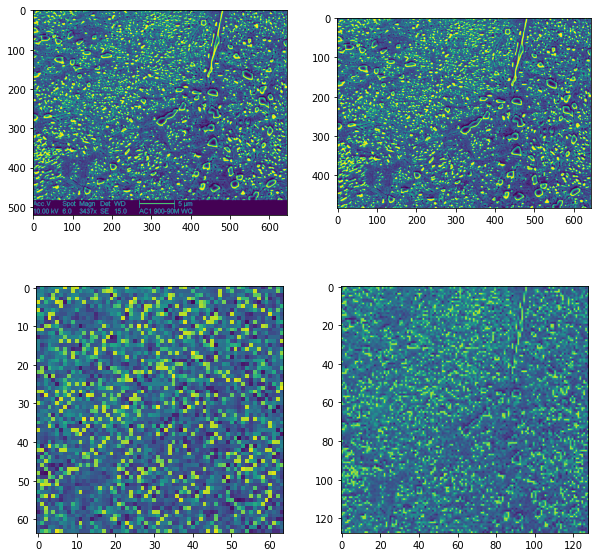

In [ ]:
data = []
plt.figure(figsize=(10,10))
for file in os.listdir(path):

    img = plt.imread(path+file)
    img=img.astype('float32')  
    plt.subplot(2, 2, 1)
    plt.imshow(img)    

    img_cropped = img[:483,:]
    plt.subplot(2, 2, 2)
    plt.imshow(img_cropped)

    img_low_res = cv2.resize(img_cropped, dsize=(64,64), interpolation=cv2.INTER_CUBIC)
    plt.subplot(2, 2, 3)
    plt.imshow(img_low_res)

    img_high_res = cv2.resize(img_cropped, dsize=(128,128), interpolation=cv2.INTER_CUBIC)
    plt.subplot(2, 2, 4)
    plt.imshow(img_high_res)

    break

Taking 64x64 scaling as we can see features are almost preserved

In [ ]:
data = []
for file in os.listdir(path):
    img = plt.imread(path+file)
    img=img.astype('float32')    
    if len(np.shape(img))==3:
        img = img[:,:,0]
    img = img[:483,:]
    img = cv2.resize(img, dsize=(64,64), interpolation=cv2.INTER_CUBIC)
    data.append(img)

In [ ]:
data = np.array(data)

In [ ]:
print(np.shape(data))

(971, 64, 64)


Previewing 100 images with original data

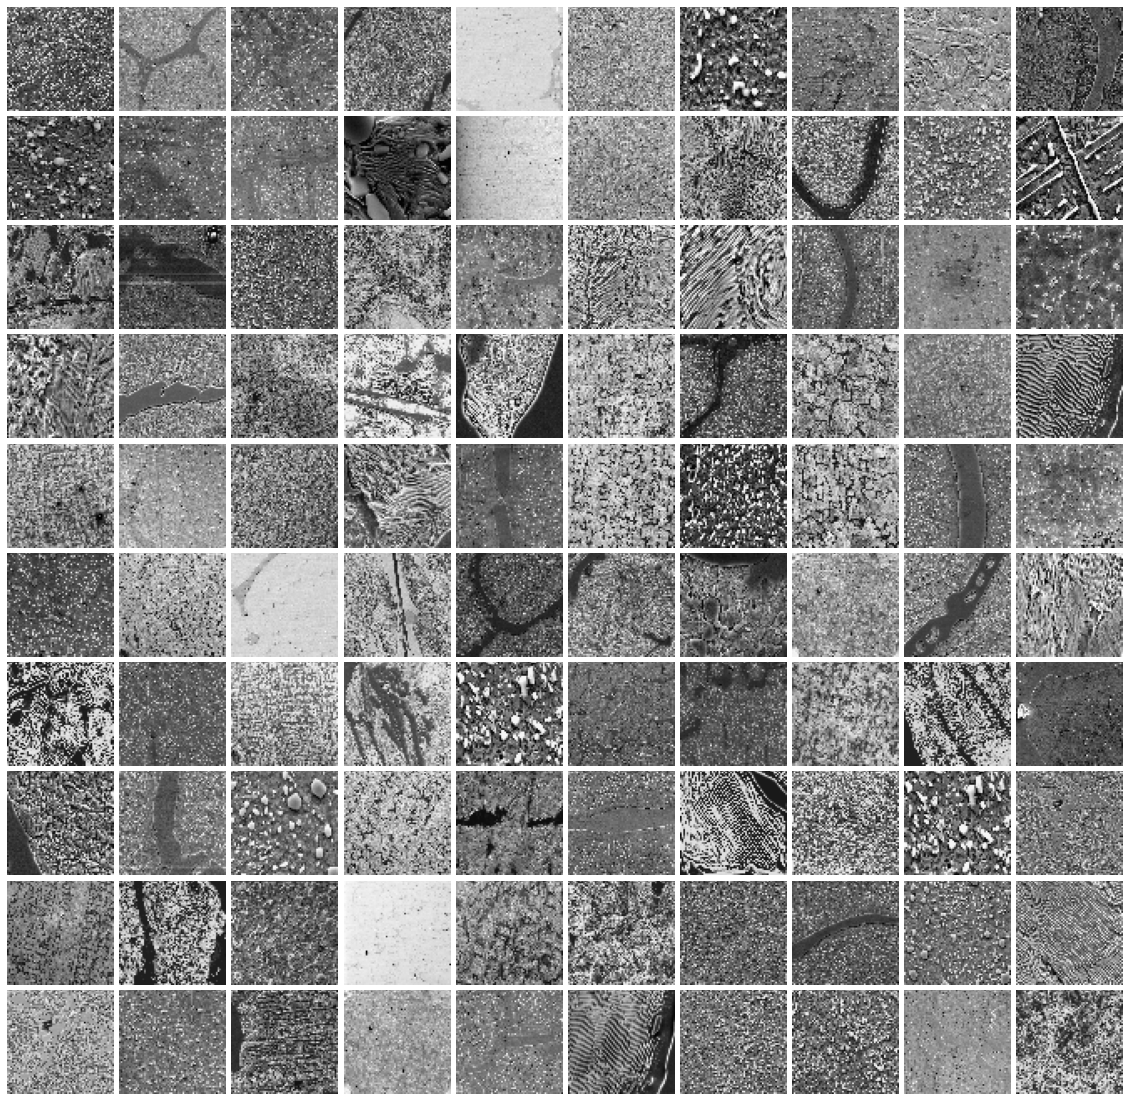

In [ ]:
max_rows = max_cols = 10
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,20))
for idx, image in enumerate(data[:100]):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    axes[row, col].imshow(image, cmap="gray", aspect="auto")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

Normalizing the data

In [ ]:
z = (data - data.mean(axis=(0), keepdims=True)) / data.std(axis=(0), keepdims=True)
z.shape

(971, 64, 64)

Previewing normalized data

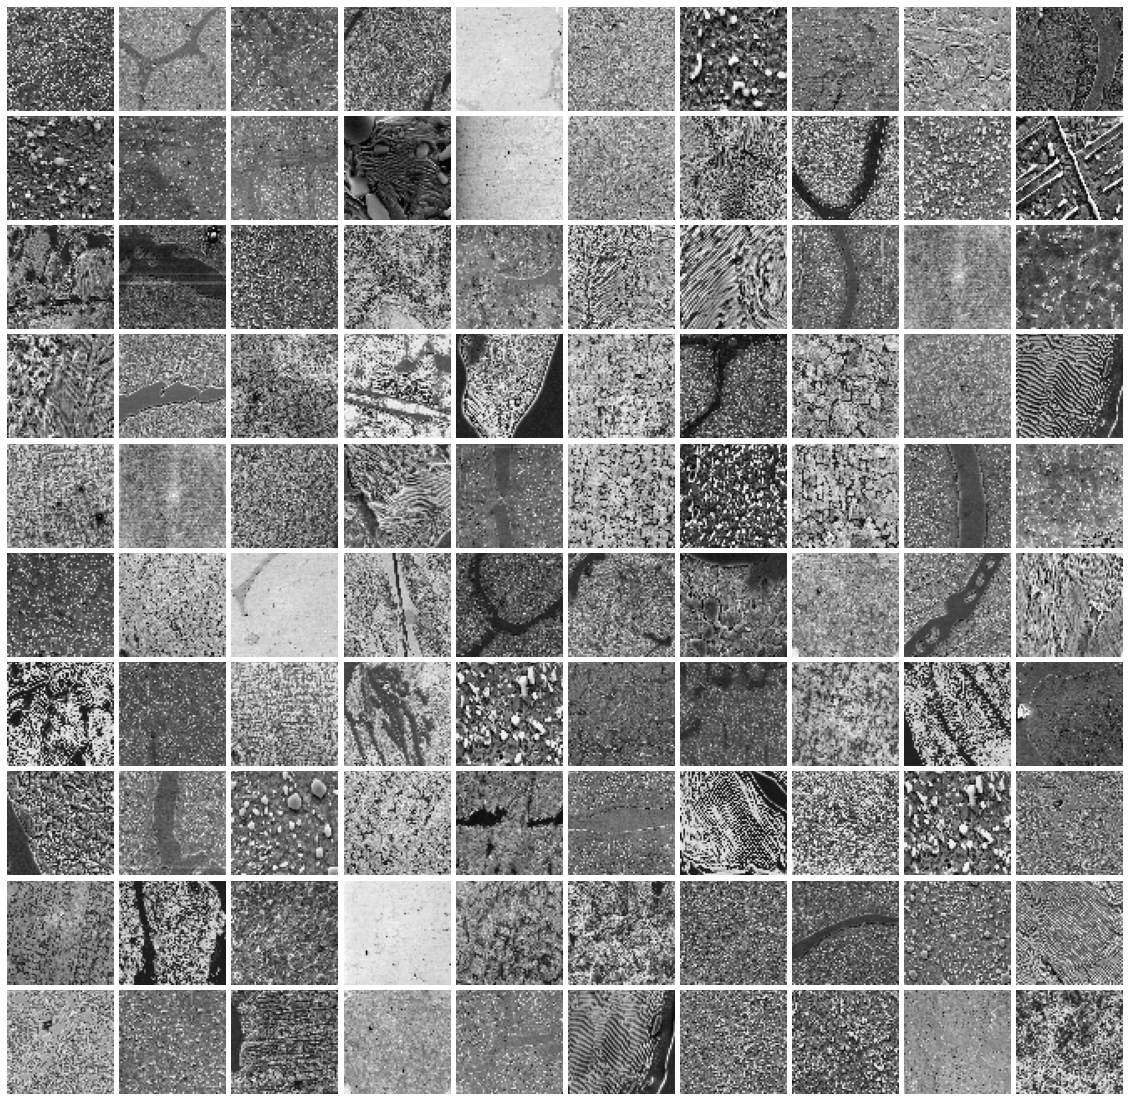

In [ ]:
max_rows = max_cols = 10
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,20))
for idx, image in enumerate(z[:100]):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    axes[row, col].imshow(image, cmap="gray", aspect="auto")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

In [ ]:
print('Max value of pixels in original data : %.3f Min value : %.3f' % (data.max(),data.min()))
print('Max value of pixels in centered data : %.3f Min value : %.3f' % (z.max(),z.min()))

Max value of pixels in original data : 325.624 Min value : -57.360
Max value of pixels in centered data : 3.033 Min value : -2.676


In [ ]:
reshaped_data = z.reshape(len(z),-1)
reshaped_data.shape

(971, 4096)

K means

In [ ]:
sse = []
list_k = list(range(2,11))
for k in list_k:
    km = KMeans(n_clusters=k)
    clusters = km.fit_predict(reshaped_data)
    sse.append(km.inertia_)

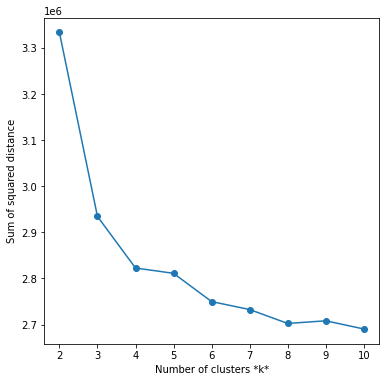

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

As we can see elbow is at K=4, so there are 4 groups of materials in the data

For visualizing clustering, taking one and two PCs so as to get 1D-2D plots

# PCA with two PCs

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca.fit(reshaped_data)

PCA(n_components=2)

In [ ]:
print(pca.explained_variance_ratio_)

[0.32386008 0.01457716]


In [ ]:
pca_data = pca.transform(reshaped_data)

In [ ]:
pca_data.shape

(971, 2)

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(pca_data)
centroids = kmeans.cluster_centers_
labels= kmeans.labels_

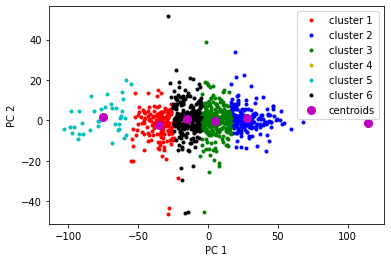

In [ ]:
plt.plot(pca_data[labels==0,0],pca_data[labels==0,1],'r.', label='cluster 1')
plt.plot(pca_data[labels==1,0],pca_data[labels==1,1],'b.', label='cluster 2')
plt.plot(pca_data[labels==2,0],pca_data[labels==2,1],'g.', label='cluster 3')
plt.plot(pca_data[labels==3,0],pca_data[labels==3,1],'y.', label='cluster 4')
plt.plot(pca_data[labels==4,0],pca_data[labels==4,1],'c.', label='cluster 5')
plt.plot(pca_data[labels==5,0],pca_data[labels==5,1],'k.', label='cluster 6')

plt.plot(centroids[:,0],centroids[:,1],'mo',markersize=8, label='centroids')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.show()

# PCA with only one PC

In [ ]:
pca = PCA(n_components=1)

In [ ]:
pca.fit(reshaped_data)

PCA(n_components=1)

In [ ]:
print(pca.explained_variance_ratio_)

[0.32386008]


In [ ]:
pca_data = pca.transform(reshaped_data)

In [ ]:
pca_data.shape

(971, 1)

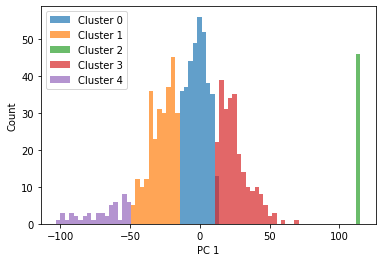

In [ ]:
cluster_id = KMeans(5).fit_predict(pca_data.reshape(-1, 1))

fig, ax = plt.subplots()
bins = np.linspace(pca_data.min(), pca_data.max(), 70)
for ii in np.unique(cluster_id):
    subset = pca_data[cluster_id==ii]
    ax.hist(subset, bins=bins, alpha=0.7, label=f"Cluster {ii}")
ax.legend()
plt.xlabel('PC 1')
plt.ylabel('Count')
plt.show()